# Multi-Class Classification Model for Glass Identification Using Python
### David Lowe
### November 7, 2019

Template Credit: Adapted from a template made available by Dr. Jason Brownlee of Machine Learning Mastery. [https://machinelearningmastery.com/]

SUMMARY: The purpose of this project is to construct a predictive model using various machine learning algorithms and to document the end-to-end steps using a template. The Glass Identification dataset is a multi-class classification situation where we are trying to predict one of several (more than two) possible outcomes.

INTRODUCTION: The dataset involves predicting, from USA Forensic Science Service, six types of glass; defined in terms of their oxide content (i.e. Na, Fe, K, etc). The study of classification of types of glass was also partly motivated by criminological investigation. At the scene of the crime, the glass left can be used as evidence…if it is correctly identified!

ANALYSIS: The baseline performance of the machine learning algorithms achieved an average accuracy of 70.35%. Two algorithms (Bagged Decision Trees and Random Forest) achieved the top accuracy metrics after the first round of modeling. After a series of tuning trials, Bagged Decision Trees turned in the top overall result and achieved an accuracy metric of 76.87%. By using the optimized parameters, the Bagged Decision Trees algorithm processed the testing dataset with an accuracy of 77.78%, which was even better than the prediction from the training data.

CONCLUSION: For this iteration, the Bagged Decision Trees algorithm achieved the best overall results using the training and test datasets. For this dataset, Bagged Decision Trees should be considered for further modeling.

Dataset Used: Glass Identification Data Set

Dataset ML Model: Multi-Class classification with numerical attributes

Dataset Reference: https://archive.ics.uci.edu/ml/datasets/glass+identification

One source of potential performance benchmarks: https://www.kaggle.com/uciml/glass

The project aims to touch on the following areas:

* Document a predictive modeling problem end-to-end.
* Explore data cleaning and transformation options
* Explore non-ensemble and ensemble algorithms for baseline model performance
* Explore algorithm tuning techniques for improving model performance

Any predictive modeling machine learning project genrally can be broken down into about six major tasks:

1. Prepare Environment
2. Summarize Data
3. Prepare Data
4. Model and Evaluate Algorithms
5. Improve Accuracy or Results
6. Finalize Model and Present Results

## Section 1 - Prepare Environment

### 1.a) Load libraries and modules

In [1]:
# Set the warning message filter
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [2]:
# Set the random seed number for reproducible results
seedNum = 888

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import os
import sys
import shutil
import urllib.request
import zipfile
import smtplib
import re
from datetime import datetime
from email.message import EmailMessage
from pandas.plotting import scatter_matrix
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import RFE
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTEENN
from imblearn.combine import SMOTETomek

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import GradientBoostingClassifier
from imblearn.ensemble import BalancedRandomForestClassifier
from imblearn.ensemble import RUSBoostClassifier
from imblearn.ensemble import BalancedBaggingClassifier
from xgboost import XGBClassifier

Using TensorFlow backend.


### 1.b) Set up the controlling parameters and functions

In [4]:
# Begin the timer for the script processing
startTimeScript = datetime.now()

# Set up the number of CPU cores available for multi-thread processing
n_jobs = -1

# Set up the flag to stop sending progress emails (setting to True will send status emails!)
notifyStatus = False

# Set the flag for splitting the dataset
splitDataset = True
splitPercentage = 0.25

# Set the number of folds for cross validation
n_folds = 10

# Set various default modeling parameters
scoring = 'accuracy'

In [5]:
# Set up the email notification function
def email_notify(msg_text):
    sender = os.environ.get('MAIL_SENDER')
    receiver = os.environ.get('MAIL_RECEIVER')
    gateway = os.environ.get('SMTP_GATEWAY')
    smtpuser = os.environ.get('SMTP_USERNAME')
    password = os.environ.get('SMTP_PASSWORD')
    if sender==None or receiver==None or gateway==None or smtpuser==None or password==None:
        sys.exit("Incomplete email setup info. Script Processing Aborted!!!")
    msg = EmailMessage()
    msg.set_content(msg_text)
    msg['Subject'] = 'Notification from Python Multi-Class Classification Script'
    msg['From'] = sender
    msg['To'] = receiver
    server = smtplib.SMTP(gateway, 587)
    server.starttls()
    server.login(smtpuser, password)
    server.send_message(msg)
    server.quit()

In [6]:
if (notifyStatus): email_notify("Library and Data Loading has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

### 1.c) Load dataset

In [7]:
dataset_path = 'https://archive.ics.uci.edu/ml/machine-learning-databases/glass/glass.data'
colNames = ['RI','Na','Mg','Al','Si','K','Ca','Ba','Fe','targetVar']
Xy_original = pd.read_csv(dataset_path, names=colNames, sep=',', header=None, index_col=0)

# Take a peek at the dataframe after the import
Xy_original.head(10)

,RI,Na,Mg,Al,Si,K,Ca,Ba,Fe,targetVar
1,1.52101,13.64,4.49,1.10,71.78,0.06,8.75,0.0,0.00,1
2,1.51761,13.89,3.60,1.36,72.73,0.48,7.83,0.0,0.00,1
3,1.51618,13.53,3.55,1.54,72.99,0.39,7.78,0.0,0.00,1
4,1.51766,13.21,3.69,1.29,72.61,0.57,8.22,0.0,0.00,1
5,1.51742,13.27,3.62,1.24,73.08,0.55,8.07,0.0,0.00,1
6,1.51596,12.79,3.61,1.62,72.97,0.64,8.07,0.0,0.26,1
7,1.51743,13.30,3.60,1.14,73.09,0.58,8.17,0.0,0.00,1
8,1.51756,13.15,3.61,1.05,73.24,0.57,8.24,0.0,0.00,1
9,1.51918,14.04,3.58,1.37,72.08,0.56,8.30,0.0,0.00,1
10,1.51755,13.00,3.60,1.36,72.99,0.57,8.40,0.0,0.11,1


In [8]:
Xy_original.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 214 entries, 1 to 214
Data columns (total 10 columns):
RI           214 non-null float64
Na           214 non-null float64
Mg           214 non-null float64
Al           214 non-null float64
Si           214 non-null float64
K            214 non-null float64
Ca           214 non-null float64
Ba           214 non-null float64
Fe           214 non-null float64
targetVar    214 non-null int64
dtypes: float64(9), int64(1)
memory usage: 18.4 KB


In [9]:
Xy_original.describe()

,RI,Na,Mg,Al,Si,K,Ca,Ba,Fe,targetVar
count,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000
mean,1.518365,13.407850,2.684533,1.444907,72.650935,0.497056,8.956963,0.175047,0.057009,2.780374
std,0.003037,0.816604,1.442408,0.499270,0.774546,0.652192,1.423153,0.497219,0.097439,2.103739
min,1.511150,10.730000,0.000000,0.290000,69.810000,0.000000,5.430000,0.000000,0.000000,1.000000
25%,1.516523,12.907500,2.115000,1.190000,72.280000,0.122500,8.240000,0.000000,0.000000,1.000000
50%,1.517680,13.300000,3.480000,1.360000,72.790000,0.555000,8.600000,0.000000,0.000000,2.000000
75%,1.519157,13.825000,3.600000,1.630000,73.087500,0.610000,9.172500,0.000000,0.100000,3.000000
max,1.533930,17.380000,4.490000,3.500000,75.410000,6.210000,16.190000,3.150000,0.510000,7.000000


In [10]:
print(Xy_original.isnull().sum())
print('Total number of NaN in the dataframe: ', Xy_original.isnull().sum().sum())

RI           0
Na           0
Mg           0
Al           0
Si           0
K            0
Ca           0
Ba           0
Fe           0
targetVar    0
dtype: int64
Total number of NaN in the dataframe:  0


### 1.d) Data Cleaning

In [11]:
# Not applicable for this iteration of the project

# Take a peek at the dataframe after the cleaning
Xy_original.head(10)

,RI,Na,Mg,Al,Si,K,Ca,Ba,Fe,targetVar
1,1.52101,13.64,4.49,1.10,71.78,0.06,8.75,0.0,0.00,1
2,1.51761,13.89,3.60,1.36,72.73,0.48,7.83,0.0,0.00,1
3,1.51618,13.53,3.55,1.54,72.99,0.39,7.78,0.0,0.00,1
4,1.51766,13.21,3.69,1.29,72.61,0.57,8.22,0.0,0.00,1
5,1.51742,13.27,3.62,1.24,73.08,0.55,8.07,0.0,0.00,1
6,1.51596,12.79,3.61,1.62,72.97,0.64,8.07,0.0,0.26,1
7,1.51743,13.30,3.60,1.14,73.09,0.58,8.17,0.0,0.00,1
8,1.51756,13.15,3.61,1.05,73.24,0.57,8.24,0.0,0.00,1
9,1.51918,14.04,3.58,1.37,72.08,0.56,8.30,0.0,0.00,1
10,1.51755,13.00,3.60,1.36,72.99,0.57,8.40,0.0,0.11,1


In [12]:
Xy_original.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 214 entries, 1 to 214
Data columns (total 10 columns):
RI           214 non-null float64
Na           214 non-null float64
Mg           214 non-null float64
Al           214 non-null float64
Si           214 non-null float64
K            214 non-null float64
Ca           214 non-null float64
Ba           214 non-null float64
Fe           214 non-null float64
targetVar    214 non-null int64
dtypes: float64(9), int64(1)
memory usage: 18.4 KB


In [13]:
Xy_original.describe()

,RI,Na,Mg,Al,Si,K,Ca,Ba,Fe,targetVar
count,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000
mean,1.518365,13.407850,2.684533,1.444907,72.650935,0.497056,8.956963,0.175047,0.057009,2.780374
std,0.003037,0.816604,1.442408,0.499270,0.774546,0.652192,1.423153,0.497219,0.097439,2.103739
min,1.511150,10.730000,0.000000,0.290000,69.810000,0.000000,5.430000,0.000000,0.000000,1.000000
25%,1.516523,12.907500,2.115000,1.190000,72.280000,0.122500,8.240000,0.000000,0.000000,1.000000
50%,1.517680,13.300000,3.480000,1.360000,72.790000,0.555000,8.600000,0.000000,0.000000,2.000000
75%,1.519157,13.825000,3.600000,1.630000,73.087500,0.610000,9.172500,0.000000,0.100000,3.000000
max,1.533930,17.380000,4.490000,3.500000,75.410000,6.210000,16.190000,3.150000,0.510000,7.000000


In [14]:
print(Xy_original.isnull().sum())
print('Total number of NaN in the dataframe: ', Xy_original.isnull().sum().sum())

RI           0
Na           0
Mg           0
Al           0
Si           0
K            0
Ca           0
Ba           0
Fe           0
targetVar    0
dtype: int64
Total number of NaN in the dataframe:  0


### 1.e) Splitting Data into Attribute-only and Target-only Sets

In [15]:
# Use variable totCol to hold the number of columns in the dataframe
totCol = len(Xy_original.columns)

# Set up variable totAttr for the total number of attribute columns
totAttr = totCol-1

# targetCol variable indicates the column location of the target/class variable
# If the first column, set targetCol to 1. If the last column, set targetCol to totCol
# If (targetCol <> 1) and (targetCol <> totCol), be aware when slicing up the dataframes for visualization
targetCol = totCol

In [16]:
# We create attribute-only and target-only datasets (X_original and y_original)
# for various visualization and cleaning/transformation operations

if targetCol == totCol:
    X_original = Xy_original.iloc[:,0:totAttr]
    y_original = Xy_original.iloc[:,totAttr]
else:
    X_original = Xy_original.iloc[:,1:totCol]
    y_original = Xy_original.iloc[:,0]

print("Xy_original.shape: {} X_original.shape: {} y_original.shape: {}".format(Xy_original.shape, X_original.shape, y_original.shape))

Xy_original.shape: (214, 10) X_original.shape: (214, 9) y_original.shape: (214,)


### 1.f) Set up the parameters for data visualization

In [17]:
# Set up the number of row and columns for visualization display. dispRow * dispCol should be >= totAttr
dispCol = 4
if totAttr % dispCol == 0 :
    dispRow = totAttr // dispCol
else :
    dispRow = (totAttr // dispCol) + 1
    
# Set figure width to display the data visualization plots
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = dispCol*4
fig_size[1] = dispRow*4
plt.rcParams["figure.figsize"] = fig_size

In [18]:
if (notifyStatus): email_notify("Library and Data Loading completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

## Section 2 - Summarize Data
To gain a better understanding of the data that we have on-hand, we will leverage a number of descriptive statistics and data visualization techniques. The plan is to use the results to consider new questions, review assumptions, and validate hypotheses that we can investigate later with specialized models.

In [19]:
if (notifyStatus): email_notify("Data Summarization and Visualization has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

### 2.a) Descriptive Statistics

#### 2.a.i) Peek at the attribute columns

In [20]:
X_original.head(10)

,RI,Na,Mg,Al,Si,K,Ca,Ba,Fe
1,1.52101,13.64,4.49,1.10,71.78,0.06,8.75,0.0,0.00
2,1.51761,13.89,3.60,1.36,72.73,0.48,7.83,0.0,0.00
3,1.51618,13.53,3.55,1.54,72.99,0.39,7.78,0.0,0.00
4,1.51766,13.21,3.69,1.29,72.61,0.57,8.22,0.0,0.00
5,1.51742,13.27,3.62,1.24,73.08,0.55,8.07,0.0,0.00
6,1.51596,12.79,3.61,1.62,72.97,0.64,8.07,0.0,0.26
7,1.51743,13.30,3.60,1.14,73.09,0.58,8.17,0.0,0.00
8,1.51756,13.15,3.61,1.05,73.24,0.57,8.24,0.0,0.00
9,1.51918,14.04,3.58,1.37,72.08,0.56,8.30,0.0,0.00
10,1.51755,13.00,3.60,1.36,72.99,0.57,8.40,0.0,0.11


#### 2.a.ii) Dimensions and attribute types

In [21]:
X_original.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 214 entries, 1 to 214
Data columns (total 9 columns):
RI    214 non-null float64
Na    214 non-null float64
Mg    214 non-null float64
Al    214 non-null float64
Si    214 non-null float64
K     214 non-null float64
Ca    214 non-null float64
Ba    214 non-null float64
Fe    214 non-null float64
dtypes: float64(9)
memory usage: 16.7 KB


#### 2.a.iii) Statistical summary of the attributes

In [22]:
X_original.describe()

,RI,Na,Mg,Al,Si,K,Ca,Ba,Fe
count,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000
mean,1.518365,13.407850,2.684533,1.444907,72.650935,0.497056,8.956963,0.175047,0.057009
std,0.003037,0.816604,1.442408,0.499270,0.774546,0.652192,1.423153,0.497219,0.097439
min,1.511150,10.730000,0.000000,0.290000,69.810000,0.000000,5.430000,0.000000,0.000000
25%,1.516523,12.907500,2.115000,1.190000,72.280000,0.122500,8.240000,0.000000,0.000000
50%,1.517680,13.300000,3.480000,1.360000,72.790000,0.555000,8.600000,0.000000,0.000000
75%,1.519157,13.825000,3.600000,1.630000,73.087500,0.610000,9.172500,0.000000,0.100000
max,1.533930,17.380000,4.490000,3.500000,75.410000,6.210000,16.190000,3.150000,0.510000


#### 2.a.iv) Summarize the levels of the class attribute

In [23]:
Xy_original.groupby('targetVar').size()

targetVar
1    70
2    76
3    17
5    13
6     9
7    29
dtype: int64

### 2.b) Data Visualization

##### 2.b.i) Univariate plots to better understand each attribute

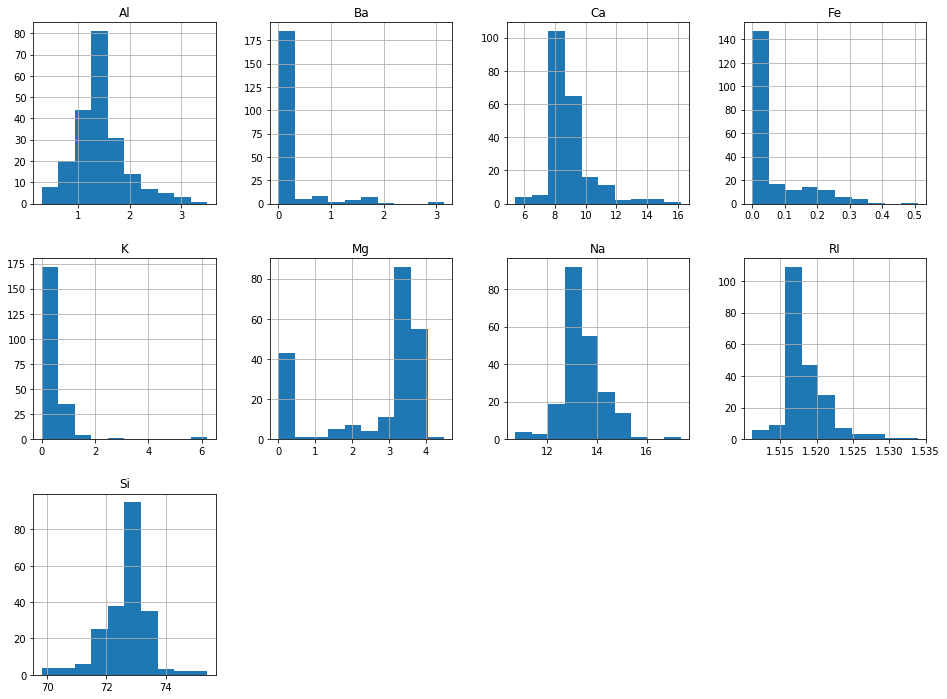

In [24]:
# Histograms for each attribute
X_original.hist(layout=(dispRow,dispCol))
plt.show()

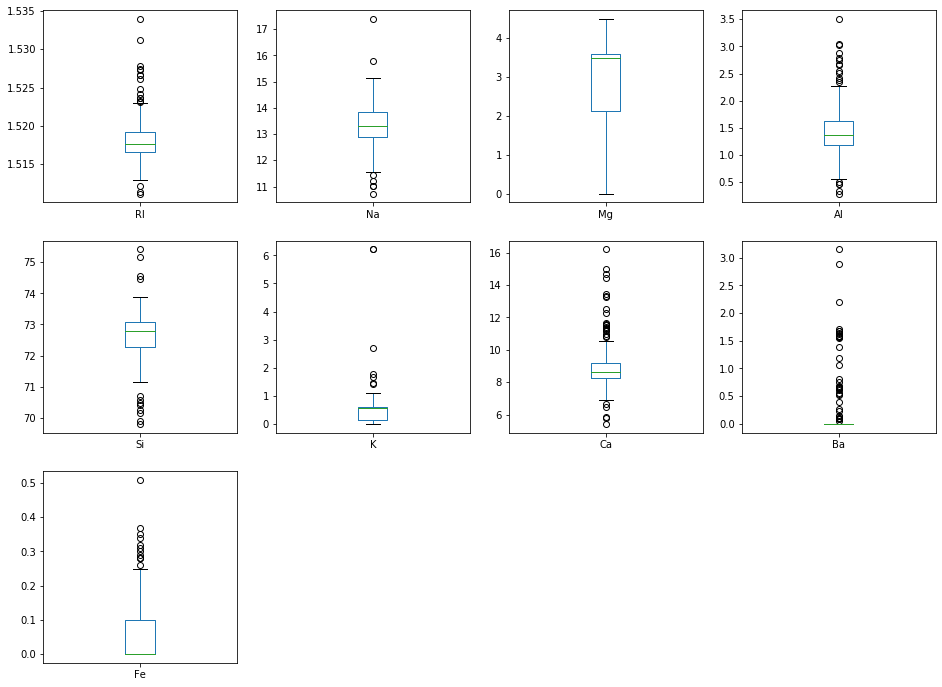

In [25]:
# Box and Whisker plot for each attribute
X_original.plot(kind='box', subplots=True, layout=(dispRow,dispCol))
plt.show()

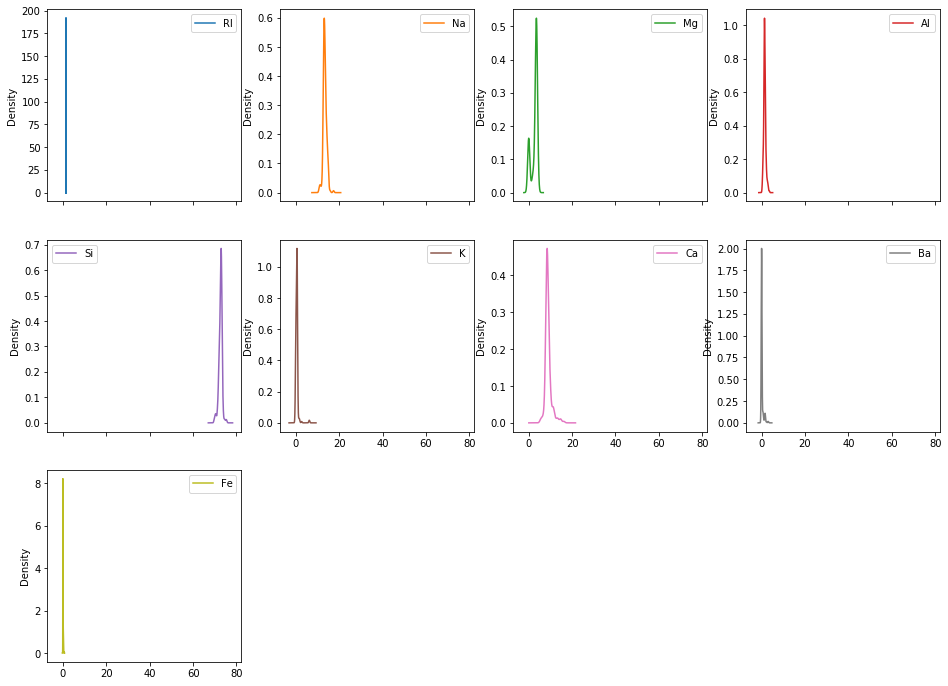

In [26]:
# Density plot for each attribute
X_original.plot(kind='density', subplots=True, layout=(dispRow,dispCol))
plt.show()

#### 2.b.ii) Multivariate plots to better understand the relationships between attributes

In [27]:
# Scatterplot matrix
# scatter_matrix(X_original)
# plt.show()

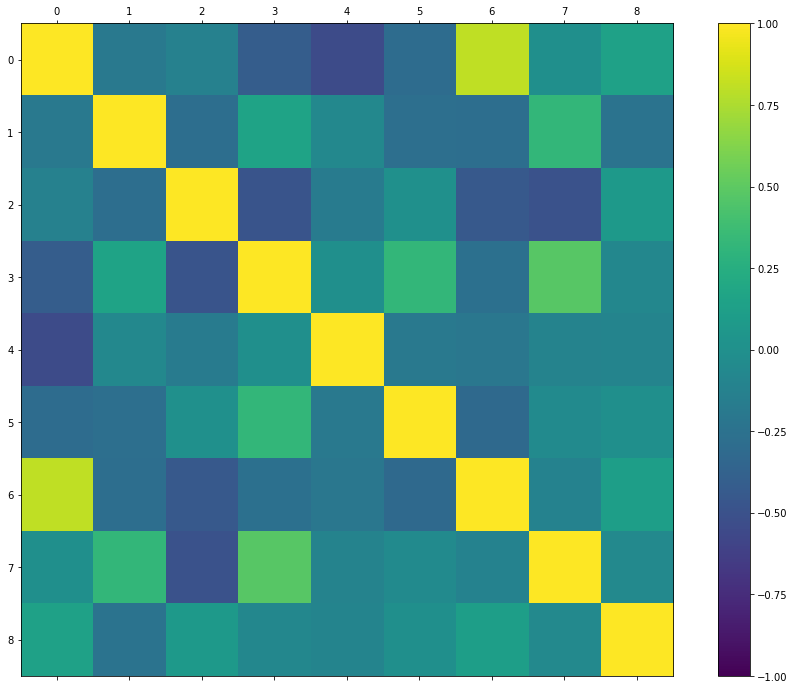

In [28]:
# Correlation matrix
fig = plt.figure(figsize=(16,12))
ax = fig.add_subplot(111)
correlations = X_original.corr(method='pearson')
cax = ax.matshow(correlations, vmin=-1, vmax=1)
fig.colorbar(cax)
plt.show()

In [29]:
if (notifyStatus): email_notify("Data Summarization and Visualization completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

## Section 3 - Prepare Data
Some dataset may require additional preparation activities that will best exposes the structure of the problem and the relationships between the input attributes and the output variable. Some data-prep tasks might include:

* Cleaning data by removing duplicates, marking missing values and even imputing missing values.
* Feature selection where redundant features may be removed.
* Data transforms where attributes are scaled or redistributed in order to best expose the structure of the problem later to learning algorithms.

In [30]:
if (notifyStatus): email_notify("Data Cleaning and Transformation has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

### 3.a) Feature Scaling and Data Pre-Processing

In [31]:
# Apply feature scaling techniques
preprocessing.scale(X_original, copy=False)

array([[ 0.87286765,  0.28495326,  1.25463857, ..., -0.14576634,
        -0.35287683, -0.5864509 ],
       [-0.24933347,  0.59181718,  0.63616803, ..., -0.79373376,
        -0.35287683, -0.5864509 ],
       [-0.72131806,  0.14993314,  0.60142249, ..., -0.82894938,
        -0.35287683, -0.5864509 ],
       ...,
       [ 0.75404635,  1.16872135, -1.86551055, ..., -0.36410319,
         2.95320036, -0.5864509 ],
       [-0.61239854,  1.19327046, -1.86551055, ..., -0.33593069,
         2.81208731, -0.5864509 ],
       [-0.41436305,  1.00915211, -1.86551055, ..., -0.23732695,
         3.01367739, -0.5864509 ]])

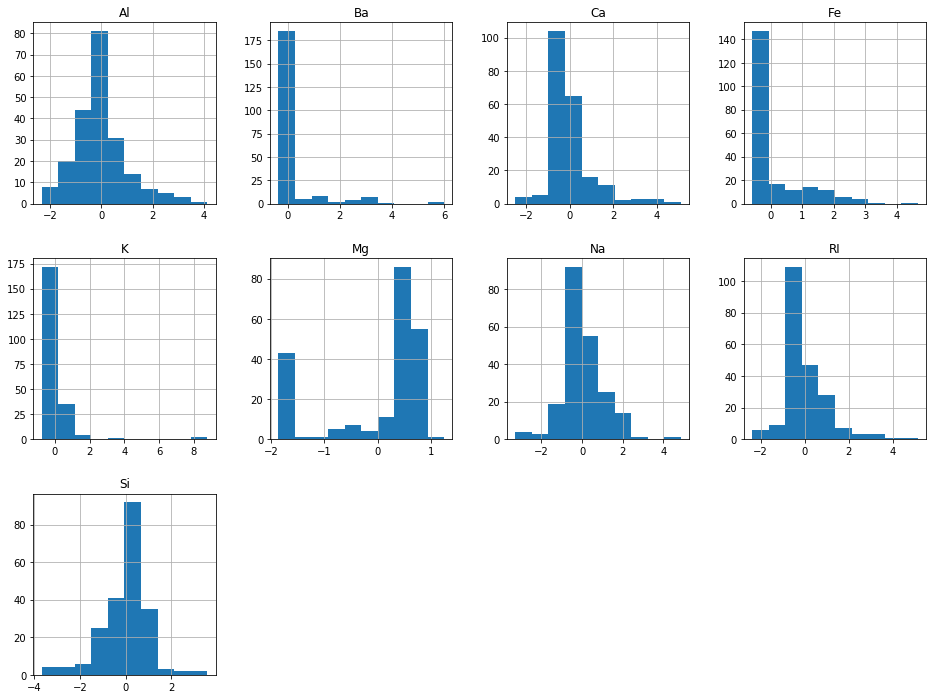

In [32]:
# Histograms for each attribute
X_original.hist(layout=(dispRow,dispCol))
plt.show()

### 3.b) Splitting Data into Training and Test Sets

In [33]:
# Split the data further into training and test datasets
if (splitDataset):
    X_train_df, X_test_df, y_train_df, y_test_df = train_test_split(X_original, y_original, test_size=splitPercentage, 
                                                                    stratify=y_original, random_state=seedNum)
else:
    X_train_df, y_train_df = X_original, y_original
    X_test_df, y_test_df = X_original, y_original
print("X_train.shape: {} y_train_df.shape: {}".format(X_train_df.shape, y_train_df.shape))
print("X_test_df.shape: {} y_test_df.shape: {}".format(X_test_df.shape, y_test_df.shape))

X_train.shape: (160, 9) y_train_df.shape: (160,)
X_test_df.shape: (54, 9) y_test_df.shape: (54,)


### 3.c) Feature Selection

In [34]:
# Not applicable for this iteration of the project

### 3.d) Display the Final Datasets for Model-Building

In [35]:
# Finalize the training and testing datasets for the modeling activities
X_train = X_train_df.to_numpy()
y_train = y_train_df.to_numpy()
X_test = X_test_df.to_numpy()
y_test = y_test_df.to_numpy()
print("X_train.shape: {} y_train.shape: {}".format(X_train.shape, y_train.shape))
print("X_test.shape: {} y_test.shape: {}".format(X_test.shape, y_test.shape))

X_train.shape: (160, 9) y_train.shape: (160,)
X_test.shape: (54, 9) y_test.shape: (54,)


In [36]:
if (notifyStatus): email_notify("Data Cleaning and Transformation completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

## 4. Model and Evaluate Algorithms
After the data-prep, we next work on finding a workable model by evaluating a subset of machine learning algorithms that are good at exploiting the structure of the training. The typical evaluation tasks include:

* Defining test options such as cross validation and the evaluation metric to use.
* Spot checking a suite of linear and nonlinear machine learning algorithms.
* Comparing the estimated accuracy of algorithms.

For this project, we will evaluate one linear, two non-linear and five ensemble algorithms:

Linear Algorithm: Linear Discriminant Analysis

Non-Linear Algorithms: Decision Trees (CART) and k-Nearest Neighbors

Ensemble Algorithms: Bagged Decision Trees, Random Forest, Extra Trees, and Gradient Boosting

The random number seed is reset before each run to ensure that the evaluation of each algorithm is performed using the same data splits. It ensures the results are directly comparable.

### 4.a) Set test options and evaluation metric

In [37]:
# Set up Algorithms Spot-Checking Array
startTimeModule = datetime.now()
train_models = []
train_results = []
train_model_names = []
train_metrics = []
train_models.append(('LDA', LinearDiscriminantAnalysis()))
train_models.append(('CART', DecisionTreeClassifier(random_state=seedNum)))
train_models.append(('KNN', KNeighborsClassifier(n_jobs=n_jobs)))
train_models.append(('BT', BaggingClassifier(random_state=seedNum, n_jobs=n_jobs)))
train_models.append(('RF', RandomForestClassifier(random_state=seedNum, n_jobs=n_jobs)))
train_models.append(('ET', ExtraTreesClassifier(random_state=seedNum, n_jobs=n_jobs)))
train_models.append(('GBM', GradientBoostingClassifier(random_state=seedNum)))
# models.append(('XGB', XGBClassifier(random_state=seedNum, n_jobs=n_jobs)))

In [38]:
# Generate model in turn
for name, model in train_models:
	if (notifyStatus): email_notify("Algorithm "+name+" modeling has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))
	startTimeModule = datetime.now()
	kfold = KFold(n_splits=n_folds, random_state=seedNum)
	cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring=scoring)
	train_results.append(cv_results)
	train_model_names.append(name)
	train_metrics.append(cv_results.mean())
	print("%s: %f (%f)" % (name, cv_results.mean(), cv_results.std()))
	print(model)
	print ('Model training time:', (datetime.now() - startTimeModule), '\n')
	if (notifyStatus): email_notify("Algorithm "+name+" modeling completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))
print ('Average metrics ('+scoring+') from all models:',np.mean(train_metrics))
print ('Total training time for all models:',(datetime.now() - startTimeModule))

LDA: 0.593750 (0.050389)
LinearDiscriminantAnalysis(n_components=None, priors=None, shrinkage=None,
                           solver='svd', store_covariance=False, tol=0.0001)
Model training time: 0:00:00.043495 

CART: 0.731250 (0.079304)
DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=888, splitter='best')
Model training time: 0:00:00.049696 

KNN: 0.693750 (0.081250)
KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=-1, n_neighbors=5, p=2,
                     weights='uniform')
Model training time: 0:00:29.129860 

BT: 0.737500 (0.067315)
BaggingClassifier(base_estimator=None, bootst

### 4.b) Spot-checking baseline algorithms

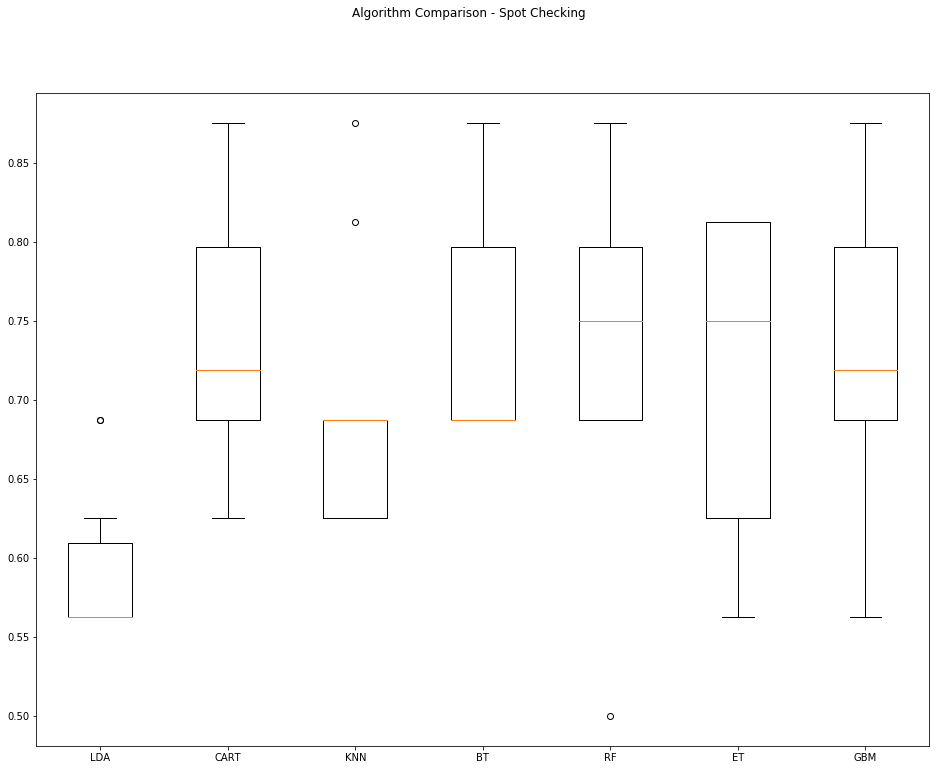

In [39]:
fig = plt.figure(figsize=(16,12))
fig.suptitle('Algorithm Comparison - Spot Checking')
ax = fig.add_subplot(111)
plt.boxplot(train_results)
ax.set_xticklabels(train_model_names)
plt.show()

## Section 5 - Improve Accuracy
After we achieve a short list of machine learning algorithms with good level of accuracy, we can leverage ways to improve the accuracy of the models.

### 5.a) Algorithm Tuning

In [40]:
# Set up the comparison array
tune_results = []
tune_names = []

In [41]:
# Tuning algorithm #1 - Bagged Decision Trees
startTimeModule = datetime.now()
if (notifyStatus): email_notify("Algorithm #1 tuning has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

tune_model1 = BaggingClassifier(random_state=seedNum, n_jobs=n_jobs)
tune_names.append('BDT')
paramGrid1 = dict(n_estimators=np.array([10,20,30,40,50]))

kfold = KFold(n_splits=n_folds, random_state=seedNum)
grid1 = GridSearchCV(estimator=tune_model1, param_grid=paramGrid1, scoring=scoring, cv=kfold)
grid_result1 = grid1.fit(X_train, y_train)

print("Best: %f using %s" % (grid_result1.best_score_, grid_result1.best_params_))
tune_results.append(grid_result1.cv_results_['mean_test_score'])
means = grid_result1.cv_results_['mean_test_score']
stds = grid_result1.cv_results_['std_test_score']
params = grid_result1.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))
print ('Model training time:',(datetime.now() - startTimeModule))
if (notifyStatus): email_notify("Algorithm #1 tuning completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

Best: 0.768750 using {'n_estimators': 40}
0.737500 (0.067315) with: {'n_estimators': 10}
0.762500 (0.078062) with: {'n_estimators': 20}
0.762500 (0.087500) with: {'n_estimators': 30}
0.768750 (0.079304) with: {'n_estimators': 40}
0.762500 (0.078062) with: {'n_estimators': 50}
Model training time: 0:05:00.004875


In [42]:
for key, value in grid_result1.best_params_.items():
    best_paramKey1 = key
    best_paramValue1 = value
print("Captured the best parameter for algorithm #1:", best_paramKey1, '=', best_paramValue1)

Captured the best parameter for algorithm #1: n_estimators = 40


In [43]:
# Tuning algorithm #2 - Random Forest
startTimeModule = datetime.now()
if (notifyStatus): email_notify("Algorithm #2 tuning has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

tune_model2 = RandomForestClassifier(random_state=seedNum, n_jobs=n_jobs)
tune_names.append('RF')
paramGrid2 = dict(n_estimators=np.array([20,40,60,80,100]))

kfold = KFold(n_splits=n_folds, random_state=seedNum)
grid2 = GridSearchCV(estimator=tune_model2, param_grid=paramGrid2, scoring=scoring, cv=kfold)
grid_result2 = grid2.fit(X_train, y_train)

print("Best: %f using %s" % (grid_result2.best_score_, grid_result2.best_params_))
tune_results.append(grid_result2.cv_results_['mean_test_score'])
means = grid_result2.cv_results_['mean_test_score']
stds = grid_result2.cv_results_['std_test_score']
params = grid_result2.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))
print ('Model training time:',(datetime.now() - startTimeModule))
if (notifyStatus): email_notify("Algorithm #2 tuning completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

Best: 0.768750 using {'n_estimators': 40}
0.712500 (0.131696) with: {'n_estimators': 20}
0.768750 (0.121995) with: {'n_estimators': 40}
0.768750 (0.104769) with: {'n_estimators': 60}
0.762500 (0.114564) with: {'n_estimators': 80}
0.756250 (0.098623) with: {'n_estimators': 100}
Model training time: 0:02:44.873418


In [44]:
for key, value in grid_result2.best_params_.items():
    best_paramKey2 = key
    best_paramValue2 = value
print("Captured the best parameter for algorithm #2:", best_paramKey2, '=', best_paramValue2)

Captured the best parameter for algorithm #2: n_estimators = 40


### 5.b) Compare Algorithms After Tuning

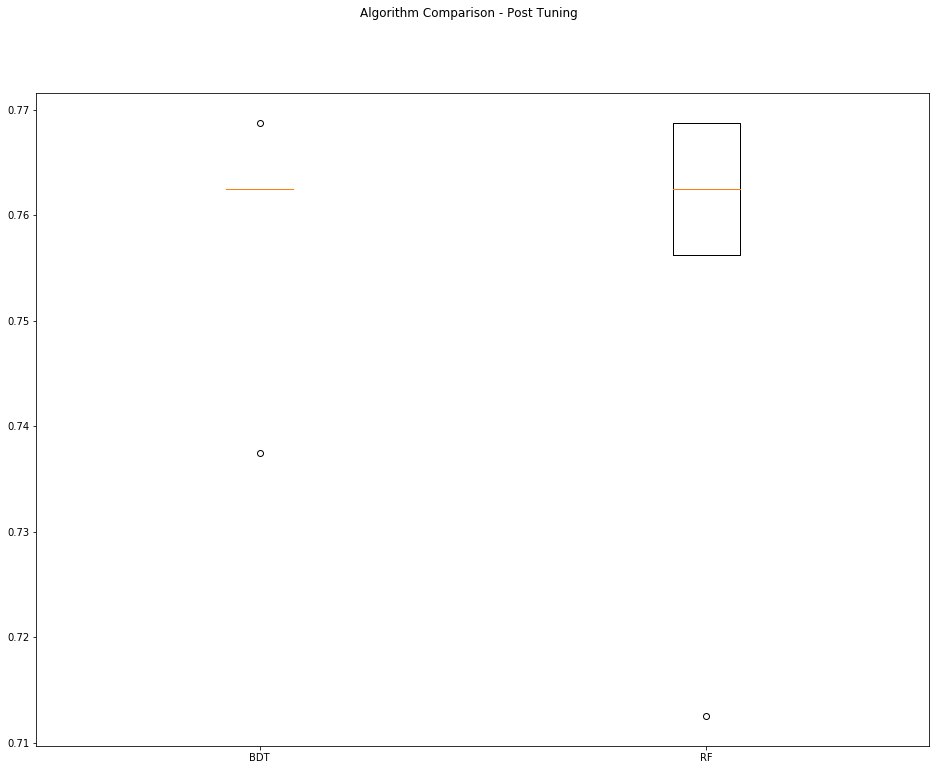

In [45]:
fig = plt.figure(figsize=(16,12))
fig.suptitle('Algorithm Comparison - Post Tuning')
ax = fig.add_subplot(111)
plt.boxplot(tune_results)
ax.set_xticklabels(tune_names)
plt.show()

## Section 6 - Finalize Model
Once we have narrow down to a model that we believe can make accurate predictions on unseen data, we are ready to finalize it. Finalizing a model may involve sub-tasks such as:
* Using an optimal model tuned to make predictions on unseen data.
* Creating a standalone model using the tuned parameters
* Saving an optimal model to file for later use.

In [46]:
if (notifyStatus): email_notify("Model Validation and Final Model Creation has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

### 6.a) Measure predictions from the test dataset

In [47]:
test_model1 = BaggingClassifier(n_estimators=best_paramValue1, random_state=seedNum, n_jobs=n_jobs)
test_model1.fit(X_train, y_train)
predictions1 = test_model1.predict(X_test)
print('Accuracy Score:', accuracy_score(y_test, predictions1))
print(confusion_matrix(y_test, predictions1))
print(classification_report(y_test, predictions1))
print(test_model1)

Accuracy Score: 0.7777777777777778
[[14  4  0  0  0  0]
 [ 2 15  0  2  0  0]
 [ 1  0  3  0  0  0]
 [ 0  1  0  1  0  1]
 [ 0  0  0  0  2  0]
 [ 0  1  0  0  0  7]]
              precision    recall  f1-score   support

           1       0.82      0.78      0.80        18
           2       0.71      0.79      0.75        19
           3       1.00      0.75      0.86         4
           5       0.33      0.33      0.33         3
           6       1.00      1.00      1.00         2
           7       0.88      0.88      0.88         8

    accuracy                           0.78        54
   macro avg       0.79      0.75      0.77        54
weighted avg       0.79      0.78      0.78        54

BaggingClassifier(base_estimator=None, bootstrap=True, bootstrap_features=False,
                  max_features=1.0, max_samples=1.0, n_estimators=40, n_jobs=-1,
                  oob_score=False, random_state=888, verbose=0,
                  warm_start=False)


In [48]:
test_model2 = RandomForestClassifier(n_estimators=best_paramValue2, random_state=seedNum, n_jobs=n_jobs)
test_model2.fit(X_train, y_train)
predictions2 = test_model2.predict(X_test)
print('Accuracy Score:', accuracy_score(y_test, predictions2))
print(confusion_matrix(y_test, predictions2))
print(classification_report(y_test, predictions2))
print(test_model2)

Accuracy Score: 0.7592592592592593
[[14  4  0  0  0  0]
 [ 0 17  0  2  0  0]
 [ 2  2  0  0  0  0]
 [ 0  1  0  1  0  1]
 [ 0  0  0  0  2  0]
 [ 0  1  0  0  0  7]]
              precision    recall  f1-score   support

           1       0.88      0.78      0.82        18
           2       0.68      0.89      0.77        19
           3       0.00      0.00      0.00         4
           5       0.33      0.33      0.33         3
           6       1.00      1.00      1.00         2
           7       0.88      0.88      0.88         8

    accuracy                           0.76        54
   macro avg       0.63      0.65      0.63        54
weighted avg       0.72      0.76      0.73        54

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,

/usr/local/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


### 6.b) Create a standalone model using all available data

In [49]:
startTimeModule = datetime.now()

# Combining the training and testing datasets to form the complete dataset that will be used for training the final model
X_complete = np.vstack((X_train, X_test))
y_complete = np.concatenate((y_train, y_test))
print("X_complete.shape: {} y_complete.shape: {}".format(X_complete.shape, y_complete.shape))

# finalModel = test_model1
# finalModel.fit(X_complete, y_complete)
print ('Model training time:',(datetime.now() - startTimeModule))

X_complete.shape: (214, 9) y_complete.shape: (214,)
Model training time: 0:00:00.000964


### 6.c) Save the final model for later use

In [50]:
# modelName = 'finalModel_MultiClass.sav'
# dump(finalModel, modelName)

In [51]:
if (notifyStatus): email_notify("Model Validation and Final Model Creation completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

In [52]:
print ('Total time for the script:',(datetime.now() - startTimeScript))

Total time for the script: 0:10:48.193355
